# Data Analysis Interview Challenge

## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

#### Import libraries/load data

In [145]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
%matplotlib inline
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [95]:
# Sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, roc_curve

In [43]:
logins = pd.read_json('logins.json')

In [44]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [45]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [46]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


#### Aggregate based on timestamps

In [47]:
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.set_index('login_time', inplace=True)

In [48]:
logins['count'] = 1

In [49]:
logins_agg_15m = logins.resample('15min').count()
logins_agg_15m.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


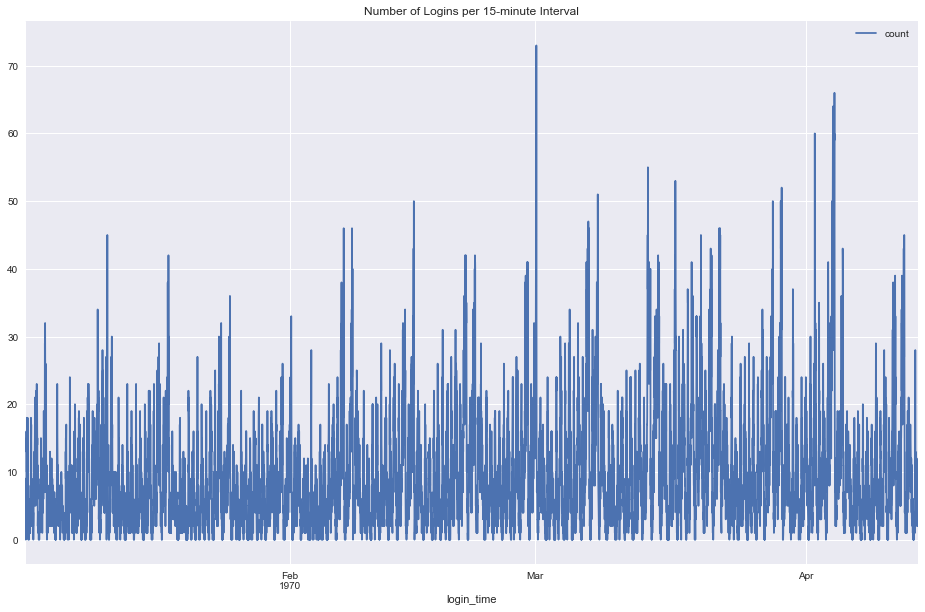

In [50]:
logins_agg_15m.plot(figsize=(16,10), title='Number of Logins per 15-minute Interval')

This data is very noisy over a 15-minute interval. It appears to be cyclical over a weekly trend. Maybe trends will be revealed over a larger time-span.

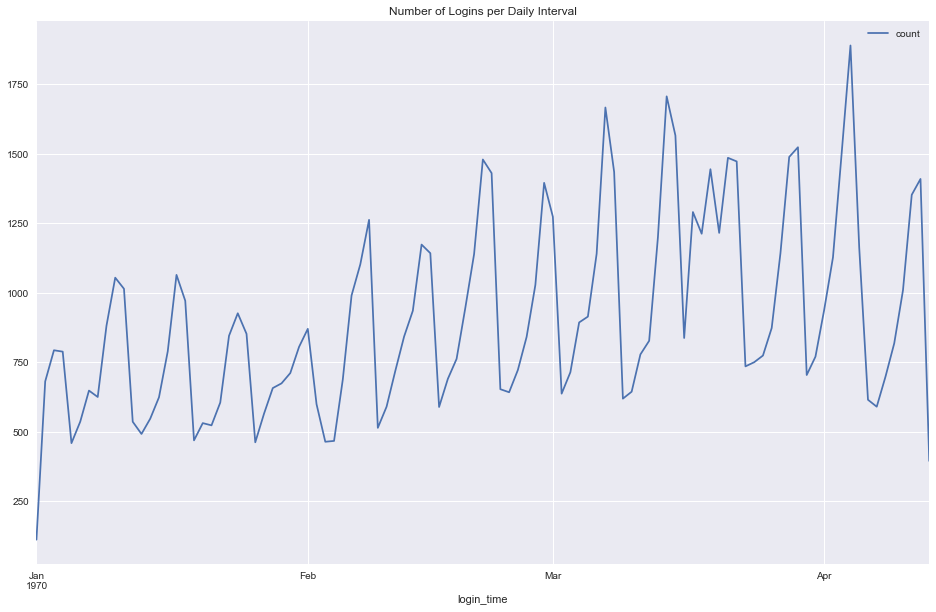

In [51]:
logins_agg_d = logins.resample('D').count()
logins_agg_d.plot(figsize=(16,10), title='Number of Logins per Daily Interval')

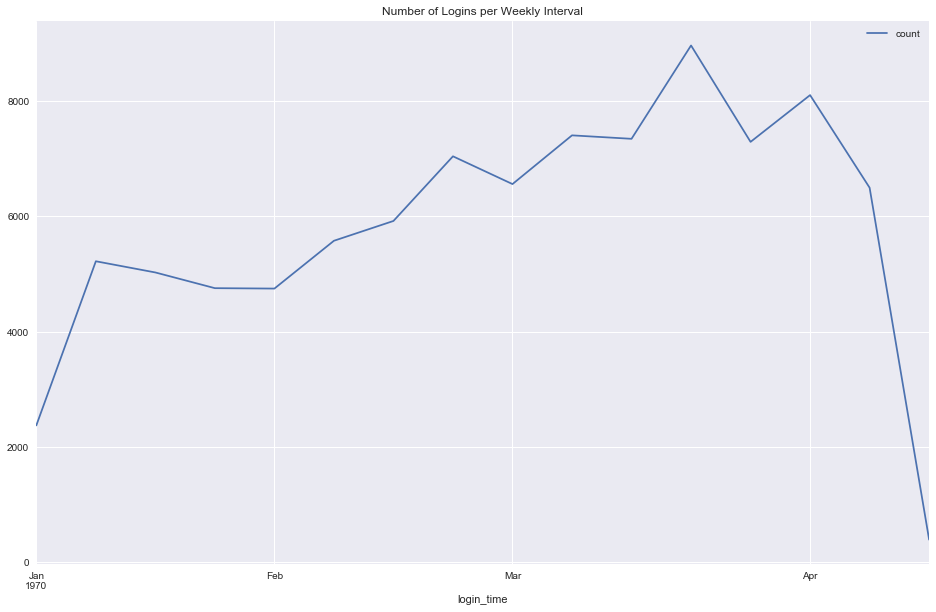

In [52]:
logins_agg_w = logins.resample('W').count()
logins_agg_w.plot(figsize=(16,10), title='Number of Logins per Weekly Interval')

Based on the weekly and monthly graphs, there is definitely a weekly spike and an overall increase in the number of users logging in. A possible drop-off at the end might be due to an artifact in the data that can be followed up with to the data engineering team.

In [53]:
logins_agg_15m= logins_agg_15m.reset_index()

logins_agg_15m['DayOfWeek'] = logins_agg_15m['login_time'].dt.dayofweek
df_weekday = logins_agg_15m.sort_values(by='count', ascending=False)
week_counts = df_weekday[['count', 'DayOfWeek']]
week_counts= week_counts.groupby('DayOfWeek').sum().reset_index()
week_counts

,DayOfWeek,count
0,0,8823
1,1,9268
2,2,10339
3,3,11960
4,4,15208
5,5,19377
6,6,18167


According to python documentation, 0 = Monday. Mapping this out we get the following:

In [54]:
week_counts['DayOfWeek'] = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']
week_counts

,DayOfWeek,count
0,Mon,8823
1,Tues,9268
2,Weds,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


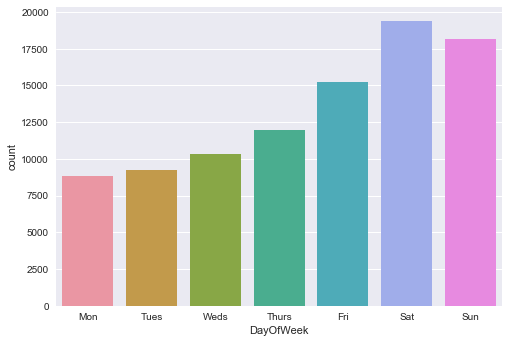

In [55]:
sns.barplot(x='DayOfWeek', y='count', data=week_counts)

This data appears to show standard trend of demand for ride-shares in a large metro city. There's a steady increase throughout the week as it closes in on the weekend, with a slight drop-off on Sundays.

In [56]:
logins_agg_15m= logins_agg_15m.reset_index()

logins_agg_15m['HrOfDay'] = logins_agg_15m['login_time'].dt.hour
df_hr = logins_agg_15m.sort_values(by='count', ascending=False)
day_counts = df_hr[['count', 'HrOfDay']]
day_counts= day_counts.groupby('HrOfDay').sum().reset_index()
day_counts

,HrOfDay,count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034
5,5,2945
6,6,1138
7,7,815
8,8,818
9,9,1527


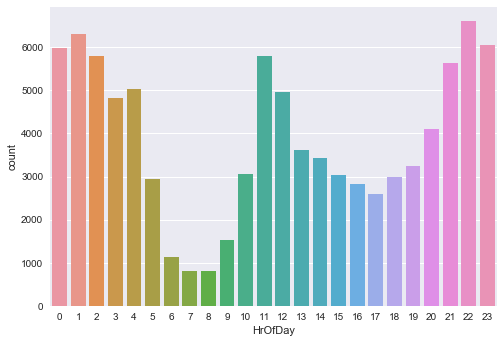

In [57]:
sns.barplot(x='HrOfDay', y='count', data=day_counts)

An interesting revelation in the data is that most logins are occurring late at night or during the middle of day. This would indicate that most people are using the application to get somewhere late at night (bar, club) rather than for daily commutes.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
  - How you will implement the experiment
  - What statistical test(s) you will conduct to verify the significance of the observation
  - How you would interpret the results and provide recommendations to the city operations team along with any caveats.

### Answer 1
I would choose a combination of three metrics:
1. The number of times drivers cross the bridge, with and without the reimbursement. If the number of crossings does not change, there is negative value in reimbursing drivers for crossing between cities.
2. The average wait time for passengers, with and without the reimbursement. If wait times for drivers increases by the number of drivers crossing between cities, riders will leave the app.
3. Amount of revenue generated, with and without the reimbursement. If the amount of revenue does not increase, there is little value in asking drivers to traverse between the cities.

### Answer 2

The Data Science team at Ultimate could perform an A/B test, keeping track of drivers who did and did not receive the reimbursement of toll costs. After a certain percentage of rides over _n_ number of days, the team can review the number crossings, average wait time, and revenue generated within each group. Then the team could apply a t-test and review the p-value to determine that the difference in values is not due to random chance.

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [58]:
json_data = json.load(open('ultimate_data_challenge.json'))
passenger_records = pd.DataFrame(json_data)

In [59]:
passenger_records.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [60]:
passenger_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [61]:
passenger_records.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [62]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

In [63]:
missing_zero_values_table(passenger_records)

Your selected dataframe has 12 columns and 50000 Rows.
There are 3 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
avg_rating_of_driver,0,8122,16.2,8122,16.2,float64
phone,0,396,0.8,396,0.8,object
avg_rating_by_driver,0,201,0.4,201,0.4,float64


In [64]:
passenger_records[passenger_records['avg_rating_of_driver'].isnull()]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0
12,20.29,5.0,NaN,1.00,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0
14,26.01,5.0,NaN,1.00,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0
15,13.20,5.0,NaN,1.00,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0
20,2.53,3.0,NaN,1.00,Winterfell,2014-03-16,Android,2014-01-31,0.0,1,False,50.0
21,3.31,5.0,NaN,1.00,Astapor,2014-04-29,iPhone,2014-01-09,0.0,1,False,100.0
22,11.47,5.0,NaN,1.00,Winterfell,2014-05-02,iPhone,2014-01-24,0.0,0,False,100.0
25,14.48,5.0,NaN,1.00,Winterfell,2014-01-03,iPhone,2014-01-02,0.0,1,True,100.0
28,5.97,5.0,NaN,1.50,Winterfell,2014-06-08,iPhone,2014-01-19,100.0,0,False,0.0


Most of the null values come from the average ratings given or received by the drivers. Let's assign the median to all missing values.

In [65]:
passenger_records['avg_rating_of_driver'] = passenger_records['avg_rating_of_driver'].fillna(value=passenger_records['avg_rating_of_driver'].median())
passenger_records['avg_rating_by_driver'] = passenger_records['avg_rating_by_driver'].fillna(value=passenger_records['avg_rating_by_driver'].median())

Check the null records were removed.

In [66]:
missing_zero_values_table(passenger_records)

Your selected dataframe has 12 columns and 50000 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
phone,0,396,0.8,396,0.8,object


### Answer to question 1
With 99.2% of the data fully present with values, let's figure out how many customers have been retained. We will do this creating a new column that is filled if the last trip date was in the last thirty days.

In [67]:
passenger_records['Retained'] = 0

In [68]:
passenger_records['last_trip_date'].max()

'2014-07-01'

In [69]:
passenger_records.loc[passenger_records['last_trip_date'] >= '2014-06-01', "Retained"] = 1

In [33]:
passenger_records.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,Retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [70]:
passenger_records['Retained'].value_counts(True)

0    0.62392
1    0.37608
Name: Retained, dtype: float64

It appears that ~38% of the users that have signed up in the dataset have taken a ride in the last 30 days.

### Answer to question 2
Now we are going to predict whether or not a user will remain active or retained in the next 30 days based on the features given (and created).

In [124]:
# One-Hot Encode Categorical Variables
# get_dummies actually removes the columns selected in addition to one-hot encoding them
passenger_records_encoded = pd.get_dummies(passenger_records, columns = ['last_trip_date','signup_date','city', 'phone', 'ultimate_black_user'])

In [126]:
# Can't leak data about the future into the predictions
columns = ['last_trip_date_2014-06-01', 'last_trip_date_2014-06-02', 'last_trip_date_2014-06-03',
          'last_trip_date_2014-06-04', 'last_trip_date_2014-06-05', 'last_trip_date_2014-06-06',
          'last_trip_date_2014-06-07','last_trip_date_2014-06-08','last_trip_date_2014-06-09',
          'last_trip_date_2014-06-10','last_trip_date_2014-06-11','last_trip_date_2014-06-12',
          'last_trip_date_2014-06-13','last_trip_date_2014-06-14','last_trip_date_2014-06-15',
          'last_trip_date_2014-06-16','last_trip_date_2014-06-17','last_trip_date_2014-06-18',
          'last_trip_date_2014-06-19','last_trip_date_2014-06-20','last_trip_date_2014-06-21',
          'last_trip_date_2014-06-22','last_trip_date_2014-06-23','last_trip_date_2014-06-24',
          'last_trip_date_2014-06-25','last_trip_date_2014-06-26','last_trip_date_2014-06-27',
          'last_trip_date_2014-06-28','last_trip_date_2014-06-29','last_trip_date_2014-06-30',
          'last_trip_date_2014-07-01',]
passenger_records_encoded.drop(columns, inplace=True, axis=1)

In [147]:
passenger_records_encoded_2 = pd.get_dummies(passenger_records, columns = ['city', 'phone', 'ultimate_black_user'] )
dates = ['last_trip_date', 'signup_date']
passenger_records_encoded_2.drop(dates, inplace=True, axis=1)

In [72]:
pd.set_option('display.max_columns', None)

In [127]:
passenger_records_encoded.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,Retained,last_trip_date_2014-01-01,last_trip_date_2014-01-02,last_trip_date_2014-01-03,last_trip_date_2014-01-04,last_trip_date_2014-01-05,last_trip_date_2014-01-06,last_trip_date_2014-01-07,last_trip_date_2014-01-08,last_trip_date_2014-01-09,last_trip_date_2014-01-10,last_trip_date_2014-01-11,last_trip_date_2014-01-12,last_trip_date_2014-01-13,last_trip_date_2014-01-14,last_trip_date_2014-01-15,last_trip_date_2014-01-16,last_trip_date_2014-01-17,last_trip_date_2014-01-18,last_trip_date_2014-01-19,last_trip_date_2014-01-20,last_trip_date_2014-01-21,last_trip_date_2014-01-22,last_trip_date_2014-01-23,last_trip_date_2014-01-24,last_trip_date_2014-01-25,last_trip_date_2014-01-26,last_trip_date_2014-01-27,last_trip_date_2014-01-28,last_trip_date_2014-01-29,last_trip_date_2014-01-30,last_trip_date_2014-01-31,last_trip_date_2014-02-01,last_trip_date_2014-02-02,last_trip_date_2014-02-03,last_trip_date_2014-02-04,last_trip_date_2014-02-05,last_trip_date_2014-02-06,last_trip_date_2014-02-07,last_trip_date_2014-02-08,last_trip_date_2014-02-09,last_trip_date_2014-02-10,last_trip_date_2014-02-11,last_trip_date_2014-02-12,last_trip_date_2014-02-13,last_trip_date_2014-02-14,last_trip_date_2014-02-15,last_trip_date_2014-02-16,last_trip_date_2014-02-17,last_trip_date_2014-02-18,last_trip_date_2014-02-19,last_trip_date_2014-02-20,last_trip_date_2014-02-21,last_trip_date_2014-02-22,last_trip_date_2014-02-23,last_trip_date_2014-02-24,last_trip_date_2014-02-25,last_trip_date_2014-02-26,last_trip_date_2014-02-27,last_trip_date_2014-02-28,last_trip_date_2014-03-01,last_trip_date_2014-03-02,last_trip_date_2014-03-03,last_trip_date_2014-03-04,last_trip_date_2014-03-05,last_trip_date_2014-03-06,last_trip_date_2014-03-07,last_trip_date_2014-03-08,last_trip_date_2014-03-09,last_trip_date_2014-03-10,last_trip_date_2014-03-11,last_trip_date_2014-03-12,last_trip_date_2014-03-13,last_trip_date_2014-03-14,last_trip_date_2014-03-15,last_trip_date_2014-03-16,last_trip_date_2014-03-17,last_trip_date_2014-03-18,last_trip_date_2014-03-19,last_trip_date_2014-03-20,last_trip_date_2014-03-21,last_trip_date_2014-03-22,last_trip_date_2014-03-23,last_trip_date_2014-03-24,last_trip_date_2014-03-25,last_trip_date_2014-03-26,last_trip_date_2014-03-27,last_trip_date_2014-03-28,last_trip_date_2014-03-29,last_trip_date_2014-03-30,last_trip_date_2014-03-31,last_trip_date_2014-04-01,last_trip_date_2014-04-02,last_trip_date_2014-04-03,last_trip_date_2014-04-04,last_trip_date_2014-04-05,last_trip_date_2014-04-06,last_trip_date_2014-04-07,last_trip_date_2014-04-08,last_trip_date_2014-04-09,last_trip_date_2014-04-10,last_trip_date_2014-04-11,last_trip_date_2014-04-12,last_trip_date_2014-04-13,last_trip_date_2014-04-14,last_trip_date_2014-04-15,last_trip_date_2014-04-16,last_trip_date_2014-04-17,last_trip_date_2014-04-18,last_trip_date_2014-04-19,last_trip_date_2014-04-20,last_trip_date_2014-04-21,last_trip_date_2014-04-22,last_trip_date_2014-04-23,last_trip_date_2014-04-24,last_trip_date_2014-04-25,last_trip_date_2014-04-26,last_trip_date_2014-04-27,last_trip_date_2014-04-28,last_trip_date_2014-04-29,last_trip_date_2014-04-30,last_trip_date_2014-05-01,last_trip_date_2014-05-02,last_trip_date_2014-05-03,last_trip_date_2014-05-04,last_trip_date_2014-05-05,last_trip_date_2014-05-06,last_trip_date_2014-05-07,last_trip_date_2014-05-08,last_trip_date_2014-05-09,last_trip_date_2014-05-10,last_trip_date_2014-05-11,last_trip_date_2014-05-12,last_trip_date_2014-05-13,last_trip_date_2014-05-14,last_trip_date_2014-05-15,last_trip_date_2014-05-16,last_trip_date_2014-05-17,last_trip_date_2014-05-18,last_trip_date_2014-05-19,last_trip_date_2014-05-20,last_trip_date_2014-05-21,last_trip_date_2014-05-22,last_trip_date_2014-05-23,last_trip_date_2014-05-24,last_trip_date_2014-05-25,last_trip_date_2014-05-26,last_trip_date_2014-05-27,last_trip_date_2014-05-28,last_trip_date_2014-05-29,last_trip_

We'll try a couple of ML algorithms (logistic regression, decision tree) to classify the `retained` variable we created.

In [148]:
# Defining our X and y variables.
x = passenger_records_encoded_2.drop(['Retained'], axis=1)
y = passenger_records_encoded_2['Retained']

In [149]:
#Scale your data
scaler = StandardScaler()
scaler.fit(x) 
X_scaled = pd.DataFrame(scaler.transform(x),columns = x.columns)

In [150]:
# Split data into a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2, random_state=12)

In [151]:
print(X_train.shape)
print(y_train.shape)

(40000, 14)
(40000,)


#### Logistic Regression

In [152]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
log_regress_y_pred = logistic_regression.predict(X_test)

In [153]:
target_names = ['Dropped', 'Retained']
print(classification_report(y_test, log_regress_y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Dropped       0.73      0.85      0.79      6241
    Retained       0.66      0.49      0.56      3759

    accuracy                           0.71     10000
   macro avg       0.70      0.67      0.67     10000
weighted avg       0.71      0.71      0.70     10000



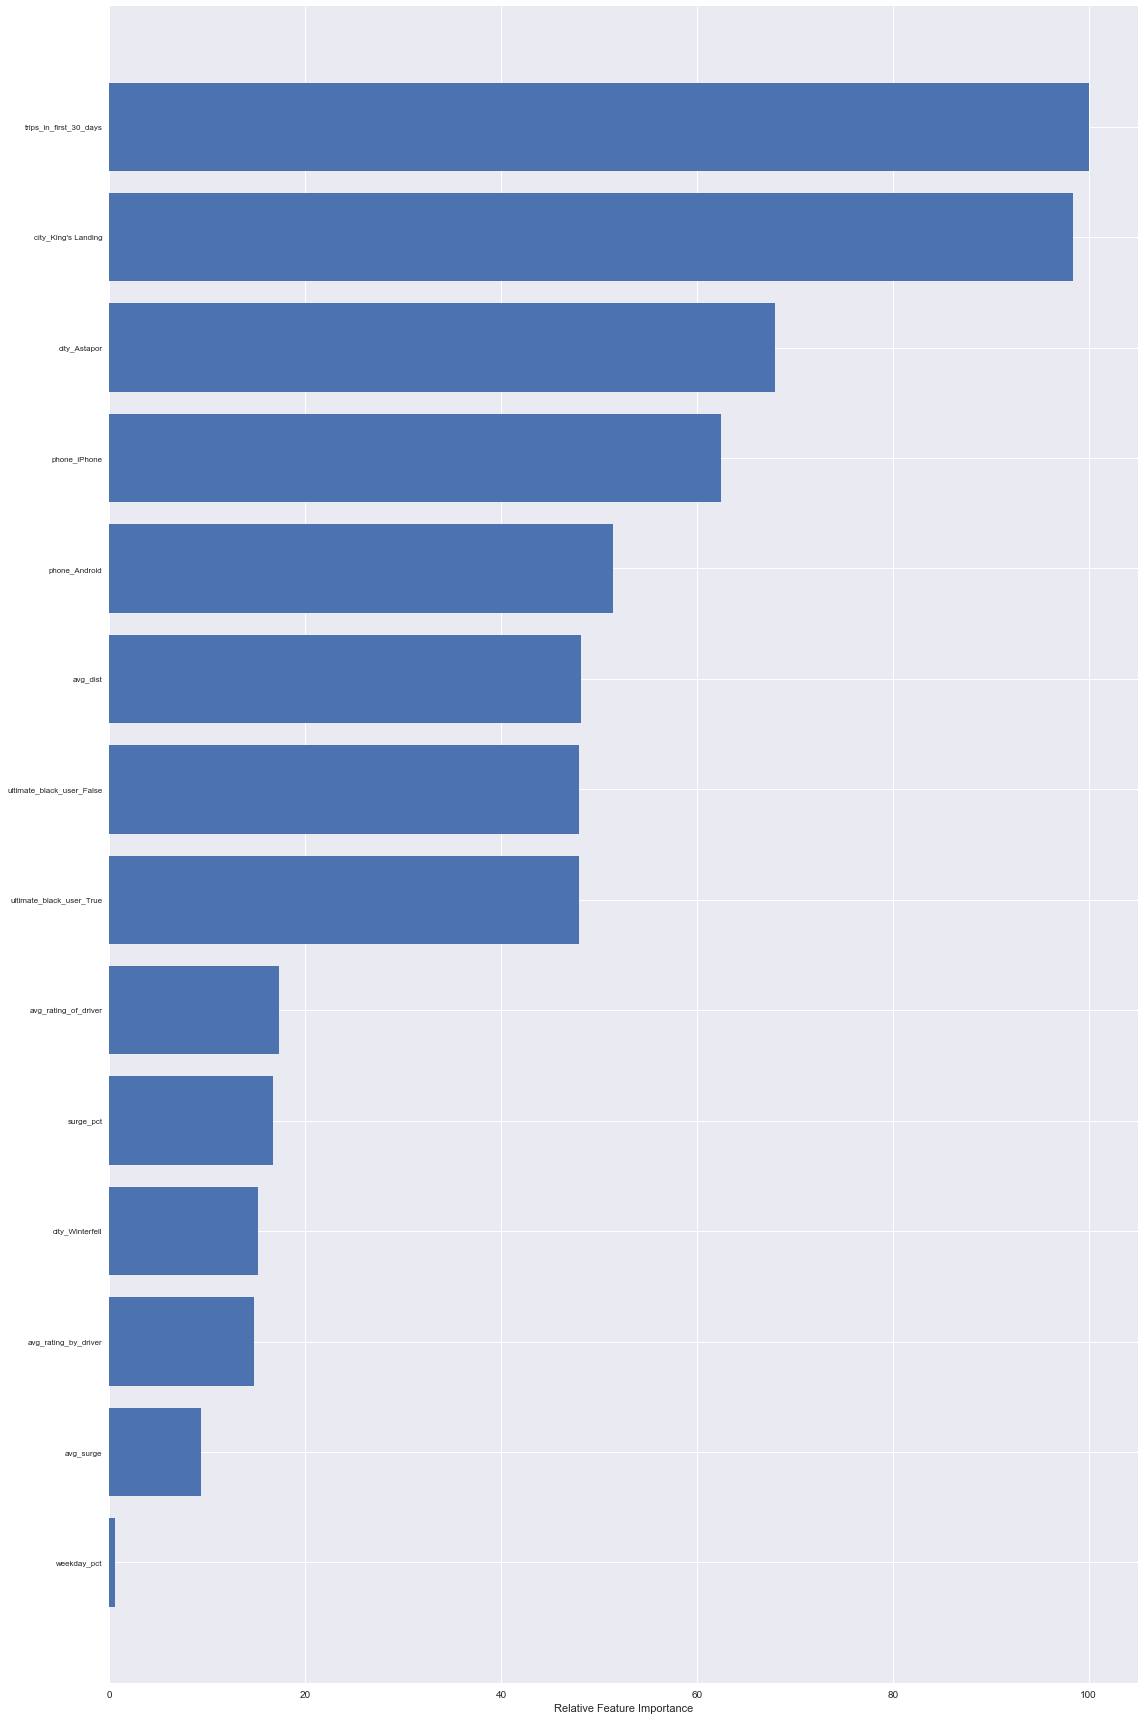

In [154]:
feature_importance = abs(logistic_regression.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(16,24))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(x.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

#### Decision Tree Classification

In [155]:
decision_tree = DecisionTreeClassifier(random_state=12)
decision_tree.fit(X_train, y_train)
decision_tree_y_pred = decision_tree.predict(X_test)

In [156]:
print(classification_report(y_test, decision_tree_y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Dropped       0.76      0.77      0.76      6241
    Retained       0.61      0.60      0.60      3759

    accuracy                           0.70     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.70      0.70      0.70     10000



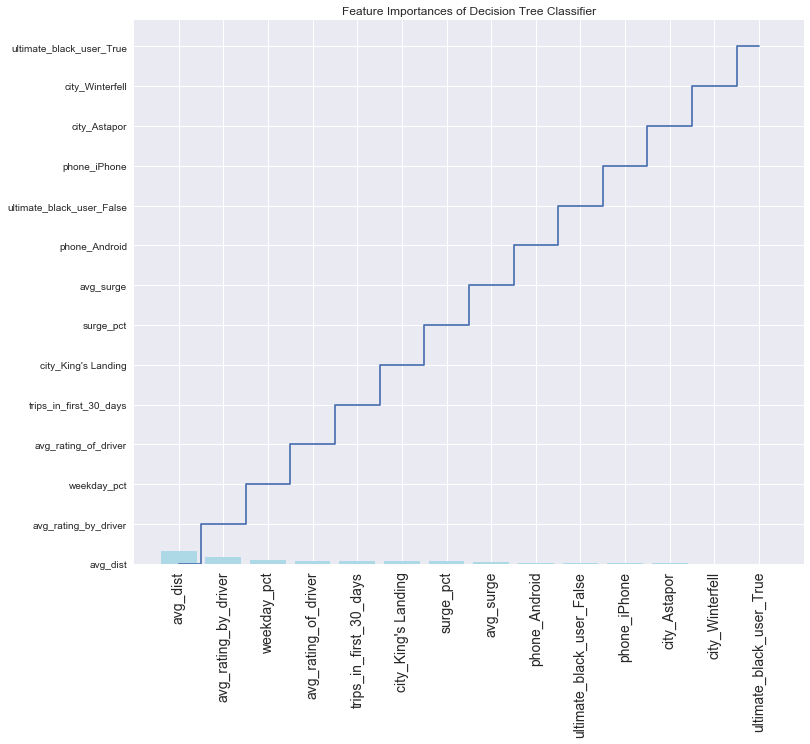

In [158]:
importances = decision_tree.feature_importances_
feat_names = x.columns

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,10))
plt.title('Feature Importances of Decision Tree Classifier')
plt.bar(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.step(range(len(indices)), feat_names[indices], where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical', fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

Based on the feature importances within the logistic regression and decision tree classifiers, I would review a few items to increase retention.
- The logistic regression model focused on the number of rides within the first 30 days. Ultimate could promote discounts within the first 30 days to get new users highly engaged.
- There is a clear difference in the engagement between King's Landing vs the other two cities. The team could do some user research stories there to determine why users are more engaged in KL.
- The distance of rides appears to matter to the decision tree classifier. The team could provide incentives for longer-distance rides.